In [1]:
DATA_PATH = 'data/aclImdb_v1/aclImdb'
DATA_ROOT = 'data/'
CLASSIFIER_ROOT = 'classifiers/'
LABELS = {'pos': 'positive', 'neg': 'negative'}

In [3]:
import os
import re
import pickle
from collections import defaultdict
import pandas as pd
import numpy as np
import string
import tempfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import nltk
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from keras.datasets import imdb
from tensorflow.python.keras.preprocessing import sequence
from tensorboard import summary as summary_lib

tf.logging.set_verbosity(tf.logging.INFO)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 9
np.random.seed(1)

Using TensorFlow backend.


# Reading Data and Split in Train and Test

In [4]:
# Read data
train_df = pd.DataFrame()
test_df = pd.DataFrame()


for directory in ('test', 'train'):
    for sentiment in ('pos', 'neg'):
        path ='{0}/{1}/{2}'.format(DATA_PATH, directory, sentiment)
        for review_file in os.listdir(path):
            with open(os.path.join(path, review_file), 'r') as input_file:
                review = input_file.read()
            if directory == 'test':
                test_df = test_df.append([[review, LABELS[sentiment]]], 
                                         ignore_index=True)
            else:
                train_df = train_df.append([[review, LABELS[sentiment]]], 
                                           ignore_index=True)

In [5]:
train_df.columns = ['review', 'sentiment']
test_df.columns = ['review', 'sentiment']
indices_train = train_df.index.tolist()
indices_test = test_df.index.tolist()
np.random.shuffle(indices_train)
np.random.shuffle(indices_test)
indices_train = np.array(indices_train)
indices_test = np.array(indices_test)
train_df = train_df.reindex(index=indices_train).dropna()
test_df = test_df.reindex(index=indices_test).dropna()
train_df['count'] = train_df['review'].apply(len)
test_df['count'] = test_df['review'].apply(len)

# Plot some simple Stats

33126741
32344810


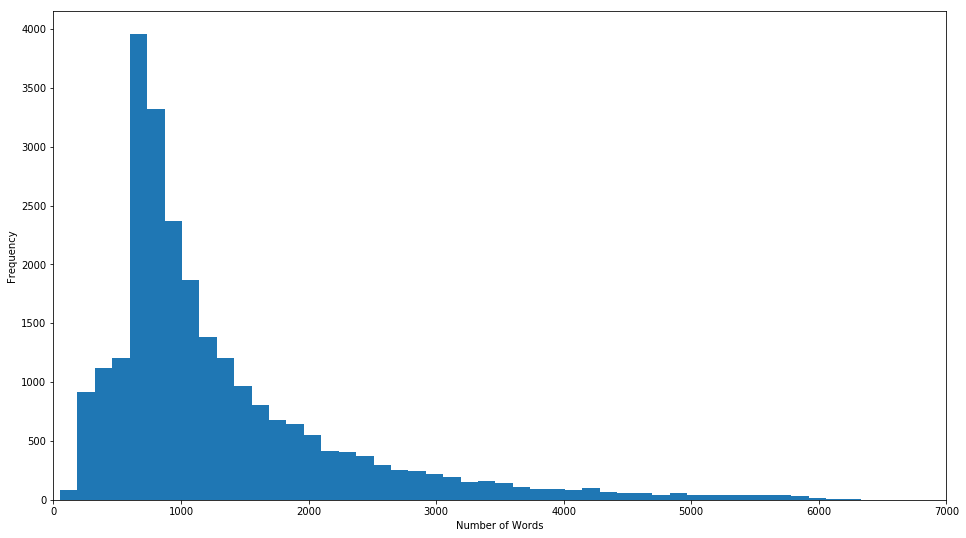

In [6]:
# Plot len stats
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 7000)
hist = plt.hist(train_df['count'], bins=100)
print(train_df['count'].sum())
print(test_df['count'].sum())

In [56]:
vocab_size = 5000
sentence_size = 200
embedding_size = 50
model_dir = 'models'

# we assign the first indices in the vocabulary to special tokens that we use
# for padding, as start token, and for indicating unknown words
pad_id = 0
start_id = 1
oov_id = 2
index_offset = 2

print("Loading data...")
(x_train_variable, y_train), (x_test_variable, y_test) = imdb.load_data(
    num_words=vocab_size, start_char=start_id, oov_char=oov_id,
    index_from=index_offset)
print(len(y_train), "train sequences")
print(len(y_test), "test sequences")

print("Pad sequences (samples x time)")
x_train = sequence.pad_sequences(x_train_variable, 
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)
x_test = sequence.pad_sequences(x_test_variable, 
                                maxlen=sentence_size,
                                truncating='post',
                                padding='post', 
                                value=pad_id)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 200)
x_test shape: (25000, 200)


In [57]:
x_len_train = np.array([min(len(x), sentence_size) for x in x_train_variable])
x_len_test = np.array([min(len(x), sentence_size) for x in x_test_variable])

def parser(x, length, y):
    features = {"x": x, "len": length}
    return features, y

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_train, x_len_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(x_train_variable))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    dataset = dataset.repeat()
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

def eval_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_test, x_len_test, y_test))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

In [58]:
all_classifiers = {}
column = tf.feature_column.categorical_column_with_identity('x', vocab_size)
def train_and_evaluate(classifier):
    # Save a reference to the classifier to run predictions later
    all_classifiers[classifier.model_dir] = classifier
    classifier.train(input_fn=train_input_fn, steps=25000)
    eval_results = classifier.evaluate(input_fn=eval_input_fn)
    predictions = np.array([p['logistic'][0] for p in classifier.predict(input_fn=eval_input_fn)])
        
    # Reset the graph to be able to reuse name scopes
    tf.reset_default_graph() 
    # Add a PR summary in addition to the summaries that the classifier writes
    pr = summary_lib.pr_curve('precision_recall', predictions=predictions, labels=y_test.astype(bool), num_thresholds=21)
    with tf.Session() as sess:
        writer = tf.summary.FileWriter(os.path.join(classifier.model_dir, 'eval'), sess.graph)
        writer.add_summary(sess.run(pr), global_step=0)
        writer.close()

In [59]:
word_embedding_column = tf.feature_column.embedding_column(column, dimension=embedding_size)
with tf.device('/gpu:0'):
    classifier = tf.estimator.DNNClassifier(
        hidden_units=[100],
        feature_columns=[word_embedding_column], 
        model_dir=os.path.join(model_dir, 'bow_embeddings'))
    train_and_evaluate(classifier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/bow_embeddings', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff5441e09b0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into models/bow_embeddings/model.ckpt.
INFO:tensorflow:loss = 69.443695, step = 1
INFO:tensorflow:global_step/sec: 89.9363
INFO:tensorflow:loss = 67.76827, step = 101 (1.111 sec)
INFO:tensorflow:global_step/sec: 116.153
INFO:tensorflow:loss = 47.667175, step = 201 (0.868 sec)
INFO:tensorflow:global_step/sec: 78.403
INFO:tensorflo

INFO:tensorflow:global_step/sec: 121.41
INFO:tensorflow:loss = 8.257562, step = 7701 (0.823 sec)
INFO:tensorflow:global_step/sec: 113.643
INFO:tensorflow:loss = 8.767857, step = 7801 (0.879 sec)
INFO:tensorflow:global_step/sec: 118.413
INFO:tensorflow:loss = 9.762995, step = 7901 (0.844 sec)
INFO:tensorflow:global_step/sec: 94.8429
INFO:tensorflow:loss = 4.136006, step = 8001 (1.055 sec)
INFO:tensorflow:global_step/sec: 120.588
INFO:tensorflow:loss = 9.870741, step = 8101 (0.829 sec)
INFO:tensorflow:global_step/sec: 118.236
INFO:tensorflow:loss = 8.223406, step = 8201 (0.846 sec)
INFO:tensorflow:global_step/sec: 111.431
INFO:tensorflow:loss = 5.4812546, step = 8301 (0.898 sec)
INFO:tensorflow:global_step/sec: 119.088
INFO:tensorflow:loss = 4.277059, step = 8401 (0.840 sec)
INFO:tensorflow:global_step/sec: 116.285
INFO:tensorflow:loss = 2.4937356, step = 8501 (0.859 sec)
INFO:tensorflow:global_step/sec: 122.712
INFO:tensorflow:loss = 4.6042595, step = 8601 (0.816 sec)
INFO:tensorflow:gl

INFO:tensorflow:loss = 0.5599106, step = 15901 (0.814 sec)
INFO:tensorflow:global_step/sec: 117.26
INFO:tensorflow:loss = 0.82008505, step = 16001 (0.853 sec)
INFO:tensorflow:global_step/sec: 123.384
INFO:tensorflow:loss = 0.9981517, step = 16101 (0.812 sec)
INFO:tensorflow:global_step/sec: 124.629
INFO:tensorflow:loss = 0.4384299, step = 16201 (0.801 sec)
INFO:tensorflow:global_step/sec: 119.323
INFO:tensorflow:loss = 0.8663263, step = 16301 (0.839 sec)
INFO:tensorflow:global_step/sec: 123.058
INFO:tensorflow:loss = 0.5182443, step = 16401 (0.813 sec)
INFO:tensorflow:global_step/sec: 119.586
INFO:tensorflow:loss = 3.725865, step = 16501 (0.835 sec)
INFO:tensorflow:global_step/sec: 120.891
INFO:tensorflow:loss = 0.47035947, step = 16601 (0.827 sec)
INFO:tensorflow:global_step/sec: 123.489
INFO:tensorflow:loss = 0.543562, step = 16701 (0.811 sec)
INFO:tensorflow:global_step/sec: 119.144
INFO:tensorflow:loss = 0.54227686, step = 16801 (0.838 sec)
INFO:tensorflow:global_step/sec: 123.567


INFO:tensorflow:global_step/sec: 121.147
INFO:tensorflow:loss = 0.1867286, step = 24101 (0.825 sec)
INFO:tensorflow:global_step/sec: 122.928
INFO:tensorflow:loss = 0.22779354, step = 24201 (0.814 sec)
INFO:tensorflow:global_step/sec: 119.015
INFO:tensorflow:loss = 0.21151084, step = 24301 (0.841 sec)
INFO:tensorflow:global_step/sec: 123.571
INFO:tensorflow:loss = 0.17644325, step = 24401 (0.808 sec)
INFO:tensorflow:global_step/sec: 119.306
INFO:tensorflow:loss = 0.17746001, step = 24501 (0.839 sec)
INFO:tensorflow:global_step/sec: 123.8
INFO:tensorflow:loss = 0.21348886, step = 24601 (0.807 sec)
INFO:tensorflow:global_step/sec: 122.74
INFO:tensorflow:loss = 0.3303159, step = 24701 (0.815 sec)
INFO:tensorflow:global_step/sec: 119.502
INFO:tensorflow:loss = 0.15483089, step = 24801 (0.837 sec)
INFO:tensorflow:global_step/sec: 123.64
INFO:tensorflow:loss = 0.20236543, step = 24901 (0.809 sec)
INFO:tensorflow:Saving checkpoints for 25000 into models/bow_embeddings/model.ckpt.
INFO:tensorfl

In [60]:
with tf.device('/gpu:1'):
    head = tf.contrib.estimator.binary_classification_head()

    def cnn_model_fn(features, labels, mode, params):    
        input_layer = tf.contrib.layers.embed_sequence(
            features['x'], vocab_size, embedding_size,
            initializer=params['embedding_initializer'])

        training = mode == tf.estimator.ModeKeys.TRAIN
        dropout_emb = tf.layers.dropout(inputs=input_layer, 
                                        rate=0.2, 
                                        training=training)

        conv = tf.layers.conv1d(
            inputs=dropout_emb,
            filters=32,
            kernel_size=3,
            padding="same",
            activation=tf.nn.relu)

        # Global Max Pooling
        pool = tf.reduce_max(input_tensor=conv, axis=1)

        hidden = tf.layers.dense(inputs=pool, units=250, activation=tf.nn.relu)

        dropout_hidden = tf.layers.dropout(inputs=hidden, 
                                           rate=0.2, 
                                           training=training)

        logits = tf.layers.dense(inputs=dropout_hidden, units=1)

        # This will be None when predicting
        if labels is not None:
            labels = tf.reshape(labels, [-1, 1])


        optimizer = tf.train.AdamOptimizer()

        def _train_op_fn(loss):
            return optimizer.minimize(
                loss=loss,
                global_step=tf.train.get_global_step())

        return head.create_estimator_spec(
            features=features,
            labels=labels,
            mode=mode,
            logits=logits, 
            train_op_fn=_train_op_fn)

    params = {'embedding_initializer': tf.random_uniform_initializer(-1.0, 1.0)}
    cnn_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,
                                            model_dir=os.path.join(model_dir, 'cnn'),
                                            params=params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/cnn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff563eab908>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [61]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18222579189548483538
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 157745152
locality {
  bus_id: 1
}
incarnation: 8249957093937596812
physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [62]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
with tf.device('/GPU:0'):
    train_and_evaluate(cnn_classifier)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into models/cnn/model.ckpt.
INFO:tensorflow:loss = 78.65312, step = 1
INFO:tensorflow:global_step/sec: 67.6303
INFO:tensorflow:loss = 68.45884, step = 101 (1.480 sec)
INFO:tensorflow:global_step/sec: 69.5858
INFO:tensorflow:loss = 57.06827, step = 201 (1.436 sec)
INFO:tensorflow:global_step/sec: 70.4667
INFO:tensorflow:loss = 51.08555, step = 301 (1.419 sec)
INFO:tensorflow:global_step/sec: 72.0588
INFO:tensorflow:loss = 50.00316, step = 401 (1.389 sec)
INFO:tensorflow:global_step/sec: 70.1908
INFO:tensorflow:loss = 42.76018, step = 501 (1.424 sec)
INFO:tensorflow:global_step/sec: 72.1908
INFO:tensorflow:loss = 44.402508, step = 601 (1.386 sec)
INFO:tensorflow:global_step/sec: 71.6698
INFO:tensorflow:loss = 38.67568, step = 701 (1.395 sec)
INFO:tensorflow:global_step/sec: 70.2124
INFO:tensorflow:loss = 46.09014, step = 801 (1.424 sec)
INFO:tensorflow:global_step/sec: 72.095
INFO:tensorflow:loss = 38.75

INFO:tensorflow:global_step/sec: 70.8381
INFO:tensorflow:loss = 5.7266164, step = 8301 (1.412 sec)
INFO:tensorflow:global_step/sec: 71.9845
INFO:tensorflow:loss = 7.01494, step = 8401 (1.390 sec)
INFO:tensorflow:global_step/sec: 70.4547
INFO:tensorflow:loss = 3.141373, step = 8501 (1.418 sec)
INFO:tensorflow:global_step/sec: 71.2851
INFO:tensorflow:loss = 7.0849457, step = 8601 (1.406 sec)
INFO:tensorflow:global_step/sec: 71.9281
INFO:tensorflow:loss = 4.2244506, step = 8701 (1.387 sec)
INFO:tensorflow:global_step/sec: 69.5239
INFO:tensorflow:loss = 5.1299734, step = 8801 (1.438 sec)
INFO:tensorflow:global_step/sec: 71.407
INFO:tensorflow:loss = 5.4265466, step = 8901 (1.401 sec)
INFO:tensorflow:global_step/sec: 69.2474
INFO:tensorflow:loss = 9.061129, step = 9001 (1.443 sec)
INFO:tensorflow:global_step/sec: 70.9246
INFO:tensorflow:loss = 14.055158, step = 9101 (1.412 sec)
INFO:tensorflow:global_step/sec: 70.4795
INFO:tensorflow:loss = 7.723854, step = 9201 (1.418 sec)
INFO:tensorflow:

INFO:tensorflow:loss = 2.3731687, step = 16501 (1.427 sec)
INFO:tensorflow:global_step/sec: 70.5614
INFO:tensorflow:loss = 5.899493, step = 16601 (1.417 sec)
INFO:tensorflow:global_step/sec: 71.5398
INFO:tensorflow:loss = 0.6877265, step = 16701 (1.397 sec)
INFO:tensorflow:global_step/sec: 70.1557
INFO:tensorflow:loss = 6.3534336, step = 16801 (1.427 sec)
INFO:tensorflow:global_step/sec: 70.5155
INFO:tensorflow:loss = 0.8822373, step = 16901 (1.418 sec)
INFO:tensorflow:global_step/sec: 68.5968
INFO:tensorflow:loss = 4.8368707, step = 17001 (1.458 sec)
INFO:tensorflow:global_step/sec: 71.6284
INFO:tensorflow:loss = 6.5343995, step = 17101 (1.396 sec)
INFO:tensorflow:global_step/sec: 70.9126
INFO:tensorflow:loss = 1.9436965, step = 17201 (1.410 sec)
INFO:tensorflow:global_step/sec: 70.1556
INFO:tensorflow:loss = 3.3979754, step = 17301 (1.426 sec)
INFO:tensorflow:global_step/sec: 70.691
INFO:tensorflow:loss = 5.4058475, step = 17401 (1.416 sec)
INFO:tensorflow:global_step/sec: 69.8748
IN

INFO:tensorflow:global_step/sec: 69.6358
INFO:tensorflow:loss = 3.7505972, step = 24801 (1.435 sec)
INFO:tensorflow:global_step/sec: 71.8178
INFO:tensorflow:loss = 3.3419385, step = 24901 (1.392 sec)
INFO:tensorflow:Saving checkpoints for 25000 into models/cnn/model.ckpt.
INFO:tensorflow:Loss for final step: 1.041292.
INFO:tensorflow:Starting evaluation at 2018-06-20-00:02:01
INFO:tensorflow:Restoring parameters from models/cnn/model.ckpt-25000
INFO:tensorflow:Finished evaluation at 2018-06-20-00:02:02
INFO:tensorflow:Saving dict for global step 25000: accuracy = 0.84428, accuracy_baseline = 0.5, auc = 0.9021762, auc_precision_recall = 0.9101126, average_loss = 0.82235724, global_step = 25000, label/mean = 0.5, loss = 82.235725, prediction/mean = 0.5114264
INFO:tensorflow:Restoring parameters from models/cnn/model.ckpt-25000


# Word Embeddings

In [63]:
if not os.path.exists('glove.6B.zip'):
    ! wget http://nlp.stanford.edu/data/glove.6B.zip
if not os.path.exists('glove.6B.50d.txt'):
    ! unzip glove.6B.zip

In [64]:
word_index = imdb.get_word_index()
word_inverted_index = {v + index_offset: k for k, v in word_index.items()}

# The first indexes in the map are reserved to represent things other than tokens
word_inverted_index[pad_id] = '<PAD>'
word_inverted_index[start_id] = '<START>'
word_inverted_index[oov_id] = '<OOV>'

for i in range(0, 10):
  print(i, word_inverted_index[i])
  
def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

print(index_to_text(x_train_variable[0]))

0 <PAD>
1 <START>
2 <OOV>
3 the
4 and
5 a
6 of
7 to
8 is
9 br
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <OOV> is an amazing actor and now the same being director <OOV> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <OOV> and would recommend it to everyone to watch and the fly <OOV> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <OOV> to the two little <OOV> that played the <OOV> of norman and paul they were just brilliant children are often left out of the <OOV> list i think because the stars that play them all grown up are such a big <OOV> for the whole film bu

In [65]:
def load_glove_embeddings(path):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            w = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embeddings[w] = vectors

    embedding_matrix = np.random.uniform(-1, 1, size=(vocab_size, embedding_size))
    num_loaded = 0
    for w, i in word_index.items():
        v = embeddings.get(w)
        if v is not None and i < vocab_size:
            embedding_matrix[i] = v
            num_loaded += 1
    print('Successfully loaded pretrained embeddings for '
          f'{num_loaded}/{vocab_size} words.')
    embedding_matrix = embedding_matrix.astype(np.float32)
    return embedding_matrix

embedding_matrix = load_glove_embeddings('glove.6B.50d.txt')

Successfully loaded pretrained embeddings for 4920/5000 words.


In [66]:
def my_initializer(shape=None, dtype=tf.float32, partition_info=None):
    assert dtype is tf.float32
    return embedding_matrix

with tf.device('gpu:0'):
    params = {'embedding_initializer': my_initializer}
    cnn_pretrained_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,
                                            model_dir=os.path.join(model_dir, 'cnn_pretrained'),
                                            params=params)
    train_and_evaluate(cnn_pretrained_classifier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/cnn_pretrained', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff4c0215358>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into models/cnn_pretrained/model.ckpt.
INFO:tensorflow:loss = 103.90302, step = 1
INFO:tensorflow:global_step/sec: 68.336
INFO:tensorflow:loss = 69.84068, step = 101 (1.464 sec)
INFO:tensorflow:global_step/sec: 70.7552
INFO:tensorflow:loss = 65.96383, step = 201 (1.413 sec)
INFO:tensorflow:global_step/sec: 69.514
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 71.8484
INFO:tensorflow:loss = 14.115187, step = 7701 (1.392 sec)
INFO:tensorflow:global_step/sec: 70.0058
INFO:tensorflow:loss = 4.242479, step = 7801 (1.429 sec)
INFO:tensorflow:global_step/sec: 71.2859
INFO:tensorflow:loss = 8.845794, step = 7901 (1.402 sec)
INFO:tensorflow:global_step/sec: 70.239
INFO:tensorflow:loss = 9.786125, step = 8001 (1.425 sec)
INFO:tensorflow:global_step/sec: 71.2238
INFO:tensorflow:loss = 8.762229, step = 8101 (1.403 sec)
INFO:tensorflow:global_step/sec: 71.249
INFO:tensorflow:loss = 12.129926, step = 8201 (1.403 sec)
INFO:tensorflow:global_step/sec: 69.6718
INFO:tensorflow:loss = 3.1307104, step = 8301 (1.436 sec)
INFO:tensorflow:global_step/sec: 71.3775
INFO:tensorflow:loss = 1.4837285, step = 8401 (1.401 sec)
INFO:tensorflow:global_step/sec: 69.5803
INFO:tensorflow:loss = 9.669699, step = 8501 (1.437 sec)
INFO:tensorflow:global_step/sec: 71.561
INFO:tensorflow:loss = 4.8047705, step = 8601 (1.399 sec)
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 69.4275
INFO:tensorflow:loss = 1.4452137, step = 16001 (1.438 sec)
INFO:tensorflow:global_step/sec: 71.0534
INFO:tensorflow:loss = 0.6128904, step = 16101 (1.409 sec)
INFO:tensorflow:global_step/sec: 70.1877
INFO:tensorflow:loss = 0.44336438, step = 16201 (1.424 sec)
INFO:tensorflow:global_step/sec: 70.1935
INFO:tensorflow:loss = 0.6120944, step = 16301 (1.425 sec)
INFO:tensorflow:global_step/sec: 71.6842
INFO:tensorflow:loss = 5.581912, step = 16401 (1.395 sec)
INFO:tensorflow:global_step/sec: 70.601
INFO:tensorflow:loss = 7.150574, step = 16501 (1.416 sec)
INFO:tensorflow:global_step/sec: 71.3971
INFO:tensorflow:loss = 3.7331784, step = 16601 (1.401 sec)
INFO:tensorflow:global_step/sec: 71.494
INFO:tensorflow:loss = 3.4720428, step = 16701 (1.398 sec)
INFO:tensorflow:global_step/sec: 70.0347
INFO:tensorflow:loss = 2.1946657, step = 16801 (1.428 sec)
INFO:tensorflow:global_step/sec: 71.0926
INFO:tensorflow:loss = 0.44322088, step = 16901 (1.407 sec)
IN

INFO:tensorflow:loss = 0.68243, step = 24201 (1.425 sec)
INFO:tensorflow:global_step/sec: 69.654
INFO:tensorflow:loss = 0.53837657, step = 24301 (1.436 sec)
INFO:tensorflow:global_step/sec: 71.4278
INFO:tensorflow:loss = 0.059497118, step = 24401 (1.400 sec)
INFO:tensorflow:global_step/sec: 69.8856
INFO:tensorflow:loss = 0.77474475, step = 24501 (1.432 sec)
INFO:tensorflow:global_step/sec: 71.6672
INFO:tensorflow:loss = 3.8311632, step = 24601 (1.396 sec)
INFO:tensorflow:global_step/sec: 71.1213
INFO:tensorflow:loss = 2.2635303, step = 24701 (1.405 sec)
INFO:tensorflow:global_step/sec: 70.1351
INFO:tensorflow:loss = 2.3134804, step = 24801 (1.426 sec)
INFO:tensorflow:global_step/sec: 71.3422
INFO:tensorflow:loss = 0.23922582, step = 24901 (1.403 sec)
INFO:tensorflow:Saving checkpoints for 25000 into models/cnn_pretrained/model.ckpt.
INFO:tensorflow:Loss for final step: 0.20108806.
INFO:tensorflow:Starting evaluation at 2018-06-20-00:08:11
INFO:tensorflow:Restoring parameters from model

In [70]:
all_classifiers_ = {'models/cnn_pretrained': all_classifiers['models/cnn_pretrained']}

In [71]:
all_classifiers

{'models/bow_embeddings': <tensorflow.python.estimator.canned.dnn.DNNClassifier at 0x7ff5661b5358>,
 'models/cnn': <tensorflow.python.estimator.estimator.Estimator at 0x7ff563eab7f0>,
 'models/cnn_pretrained': <tensorflow.python.estimator.estimator.Estimator at 0x7ff563eab470>}

In [72]:
def text_to_index(sentence):
    # Remove punctuation characters except for the apostrophe
    translator = str.maketrans('', '', string.punctuation.replace("'", ''))
    tokens = sentence.translate(translator).lower().split()
    return np.array([1] + [word_index[t] if t in word_index else oov_id for t in tokens])

def print_predictions(sentences):
    indexes = [text_to_index(sentence) for sentence in sentences]
    x = sequence.pad_sequences(indexes, 
                               maxlen=sentence_size, 
                               truncating='post',
                               padding='post',
                               value=pad_id)
    length = np.array([min(len(x), sentence_size) for x in indexes])
    predict_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": x, "len": length}, shuffle=False)
    predictions = {}
    for path, classifier in all_classifiers_.items():
        predictions[path] = [p['logistic'][0] for p in classifier.predict(input_fn=predict_input_fn)]
    for idx, sentence in enumerate(sentences):
        print(sentence)
        for path in all_classifiers_:
            print("\t{} {}".format(path, predictions[path][idx]))
            

In [77]:
print_predictions([
    'I really liked the movie! This movie is perfect',
    'I hate this movie a lot.',
    'For a '])

INFO:tensorflow:Restoring parameters from models/cnn_pretrained/model.ckpt-25000
I really liked the movie! This movie is perfect
	models/cnn_pretrained 0.982054591178894
I hate this movie a lot.
	models/cnn_pretrained 0.34777140617370605
Hated every second of it a lot. Worst movie..
	models/cnn_pretrained 0.4714236259460449


In [55]:
tensorboard --logdir={model_dir}

SyntaxError: can't assign to operator (<ipython-input-55-009fd6a9785d>, line 1)

In [10]:
# Kfold Cross Validation
def k_fold_validation(classifier, X_train, Y_train, get_classifier, n_splits=10):
    acc = []
    kf = KFold(n_splits=n_splits)
    for train_index, test_index in kf.split(X_train):
        X_kf_train, X_kf_test = X_train[train_index], X_train[test_index]
        Y_kf_train, Y_kf_test = Y_train[train_index], Y_train[test_index]
        # train classifier and tranform X_kf_test data
        trained_classifier, X_kf_test, _ = get_classifier(classifier, X_kf_train, Y_kf_train, X_kf_test)
        Y_predicted = trained_classifier.predict(X_kf_test)
        acc.append(accuracy_score(Y_predicted, Y_kf_test))
    return np.mean(acc)

In [11]:
# Bag of words classifier
def bag_of_words_classifier(classifier, X_train, Y_train, X_test=None):    
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X_train)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    clf = classifier.fit(X_train_tfidf, Y_train)
    X_test_tfidf = None   
    if X_test is not None:
        X_test_counts = count_vect.transform(X_test)
        X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    return clf, X_test_tfidf, [count_vect, tfidf_transformer]

In [12]:
X_train = train_df['review_lemma'].values
Y_train = train_df['sentiment'].values

# Calculate CV score
clf = MultinomialNB()
nb_accuracy = k_fold_validation(clf, X_train, Y_train, bag_of_words_classifier, n_splits=10)
print("Naive Bayes Accuracy = {0}".format(nb_accuracy))

Naive Bayes Accuracy = 0.86364


In [19]:
clf = DecisionTreeClassifier(random_state=0)
dt_accuracy = k_fold_validation(clf, X_train, Y_train, bag_of_words_classifier, n_splits=10)
print("Decision Tree Accuracy = {0}".format(dt_accuracy))

Decision Tree Accuracy = 0.71288


In [20]:
# Train classifier using all train data
TRAIN_ALL_DATA = True
if TRAIN_ALL_DATA:
    clf_nb, _, transformers = bag_of_words_classifier(MultinomialNB(), X_train, Y_train)
    clf_dt, _, transformers = bag_of_words_classifier(DecisionTreeClassifier(random_state=0), X_train, Y_train)

# Persist the models
SAVE_MODEL = True
if TRAIN_ALL_DATA and SAVE_MODEL:
    pickle.dump(clf_nb, open('{0}/nb.sav'.format(CLASSIFIER_ROOT), 'wb'))
    pickle.dump(clf_dt, open('{0}/dt.sav'.format(CLASSIFIER_ROOT), 'wb'))
    pickle.dump(transformers[0], open('{0}/transform_bag_of_words_0.sav'.format(CLASSIFIER_ROOT), 'wb'))
    pickle.dump(transformers[1], open('{0}/transform_bag_of_words_1.sav'.format(CLASSIFIER_ROOT), 'wb'))